# Dataset 2 ECG Image Classification
# Importing required Library

In [79]:
import pandas as pd
import os
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

### Checking the path files

In [142]:
for dirname, _, filenames in os.walk(os.getcwd()):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:\Users\user\Projects\ML\MachineLearningGroup12\Dataset 2 ECGImageClassification\.DS_Store
C:\Users\user\Projects\ML\MachineLearningGroup12\Dataset 2 ECGImageClassification\ECG image classification.ipynb
C:\Users\user\Projects\ML\MachineLearningGroup12\Dataset 2 ECGImageClassification\.ipynb_checkpoints\ECG image classification-checkpoint.ipynb
C:\Users\user\Projects\ML\MachineLearningGroup12\Dataset 2 ECGImageClassification\ECG_DATA\.DS_Store
C:\Users\user\Projects\ML\MachineLearningGroup12\Dataset 2 ECGImageClassification\ECG_DATA\test\.DS_Store
C:\Users\user\Projects\ML\MachineLearningGroup12\Dataset 2 ECGImageClassification\ECG_DATA\test\ECG Images of Myocardial Infarction Patients (240x12=2880)\MI(1).jpg
C:\Users\user\Projects\ML\MachineLearningGroup12\Dataset 2 ECGImageClassification\ECG_DATA\test\ECG Images of Myocardial Infarction Patients (240x12=2880)\MI(10).jpg
C:\Users\user\Projects\ML\MachineLearningGroup12\Dataset 2 ECGImageClassification\ECG_DATA\test\ECG Images of Myoc

In [144]:
train_dir = 'ECG_DATA/train'
test_dir = 'ECG_DATA/test'

### Importing the Dataset

In [146]:
def get_subfolders_and_image_counts(directory):
    subfolders = {}
    for subdir, dirs, files in os.walk(directory):
        if dirs:
            for folder in dirs:
                folder_path = os.path.join(subdir, folder)
                num_images = len([file for file in os.listdir(folder_path) if file.endswith(('.png', '.jpg', '.jpeg'))])
                subfolders[folder] = num_images
    return subfolders

train_subfolders = get_subfolders_and_image_counts(train_dir)
test_subfolders = get_subfolders_and_image_counts(test_dir)

In [148]:
print("Training Subfolders and Image Counts:")
for folder, count in train_subfolders.items():
    print(f"{folder}: {count} images")

print("\nTest Subfolders and Image Counts:")
for folder, count in test_subfolders.items():
    print(f"{folder}: {count} images")

Training Subfolders and Image Counts:
ECG Images of Myocardial Infarction Patients (240x12=2880): 956 images
ECG Images of Patient that have abnormal heartbeat (233x12=2796): 699 images
ECG Images of Patient that have History of MI (172x12=2064): 516 images
Normal Person ECG Images (284x12=3408): 852 images

Test Subfolders and Image Counts:
ECG Images of Myocardial Infarction Patients (240x12=2880): 239 images
ECG Images of Patient that have abnormal heartbeat (233x12=2796): 233 images
ECG Images of Patient that have History of MI (172x12=2064): 172 images
Normal Person ECG Images (284x12=3408): 284 images


# Data Augmentation using Image Data Generator

In [150]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  
    ,rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'

)

test_datagen = ImageDataGenerator(rescale=1./255)

# Creating the Augumented Data

In [152]:
def dataGenerator(train_dir,test_dir):
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),  
        batch_size=32,
        class_mode='categorical',color_mode='grayscale', # Clss_mode = 'categorical 'simplifies that its one hot encoded
        subset='training'  
    )

    validation_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',color_mode='grayscale',
        subset='validation'  
    )
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),color_mode='grayscale',
        batch_size=32,
        class_mode='categorical'
    )

    return train_generator,validation_generator, test_generator
# print("Class indices:", train_generator.class_indices)

In [154]:
trainGenerated, validationGenerated, testGenerated = dataGenerator(train_dir,test_dir)

Found 2420 images belonging to 4 classes.
Found 603 images belonging to 4 classes.
Found 928 images belonging to 4 classes.


In [156]:
print("Class indices:", trainGenerated.class_indices)

Class indices: {'ECG Images of Myocardial Infarction Patients (240x12=2880)': 0, 'ECG Images of Patient that have History of MI (172x12=2064)': 1, 'ECG Images of Patient that have abnormal heartbeat (233x12=2796)': 2, 'Normal Person ECG Images (284x12=3408)': 3}


# Graph funtion for the Training Accuracy vs Epochs Graph

In [158]:
def graphs(history): 
    # Accuracy plot
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Loss plot
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# MLP ALGORITHM

In [180]:
def mlpModelFun(trainGenerated, validationGenerated):
    mlpModel = models.Sequential([
        layers.Input(shape=(224, 224, 1)),
        layers.Flatten(),

        layers.Dense(256,activation='relu'),
        layers.Dropout(0.1),

        layers.Dense(128,activation='relu'),
        layers.Dropout(0.1),

        layers.Dense(64,activation='relu'),
        layers.Dropout(0.1),

        layers.Dense(len(trainGenerated.class_indices), activation='softmax')
    ])

    mlpModel.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    
    history = mlpModel.fit(
    trainGenerated,
    steps_per_epoch=trainGenerated.samples // trainGenerated.batch_size,
    validation_data=validationGenerated,
    validation_steps=validationGenerated.samples // validationGenerated.batch_size,
    epochs=25  
    )
    return history

Epoch 1/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.2538 - loss: 17.7373 - val_accuracy: 0.3229 - val_loss: 1.3852
Epoch 2/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.2500 - loss: 1.3870 - val_accuracy: 0.1852 - val_loss: 1.3871
Epoch 3/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 197s 3s/step - accuracy: 0.3086 - loss: 1.4016 - val_accuracy: 0.3177 - val_loss: 1.3746
Epoch 4/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.2812 - loss: 1.3738 - val_accuracy: 0.2963 - val_loss: 1.3788
Epoch 5/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.3218 - loss: 1.3843 - val_accuracy: 0.3194 - val_loss: 1.3655
Epoch 6/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.1875 - loss: 1.3717 - val_accuracy: 0.2593 - val_loss: 1.3841
Epoch 7/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 196s 3s/step - accuracy: 0.3168 - loss: 1.3650 - val_accuracy: 0.3142 - val_loss: 1.3628
Epoch 8/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.2500 - loss: 1.4101 - val_accuracy: 0.3704 - 

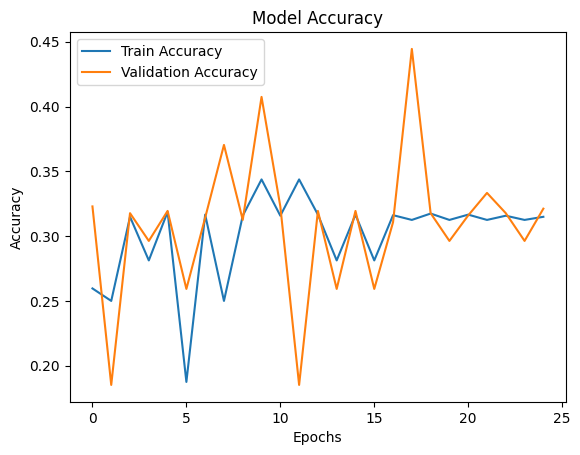

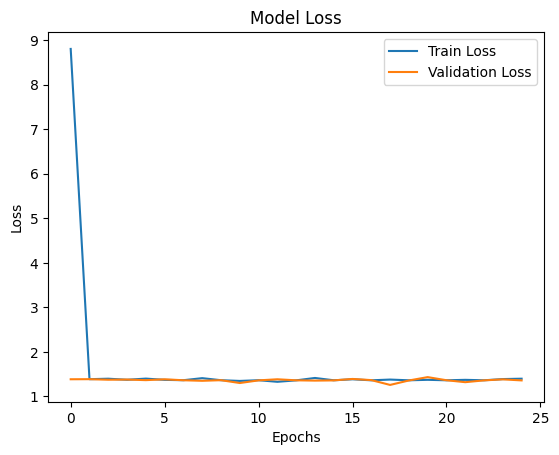

In [182]:
mlpModelHistory = mlpModelFun(trainGenerated, validationGenerated)
graphs(mlpModelHistory)

# CNN ALGORITHM

In [183]:
from tensorflow.keras import models, layers, regularizers
def cnnModel():
    model = models.Sequential([
        # First Conv Layer with L2 regularization
        layers.Conv2D(32, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.001) ,input_shape=(224, 224, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),  # Dropout layer to prevent overfitting

        # Second Conv Layer with L2 regularization
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Third Conv Layer with L2 regularization
        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Fourth Conv Layer with L2 regularization
        layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Flatten and Dense Layers
        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),  # Higher dropout rate for Dense layer])

        layers.Dense(4,activation='softmax')
    ])


    model.summary()
    
    model.compile(optimizer='RMSprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    history = model.fit(
    trainGenerated,
    steps_per_epoch=trainGenerated.samples // trainGenerated.batch_size,
    validation_data=validationGenerated,
    validation_steps=validationGenerated.samples // validationGenerated.batch_size,
    epochs=25  
    )   

    return model, history
    

In [184]:
cnnModel, cnnModelHistory = cnnModel()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 222, 222, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_47 (Dropout)                 │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_48 (Dropout)                 │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_49 (Dropout)                 │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_50 (Dropout)                 │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_13 (Flatten)                 │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 128)                 │       4,718,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_51 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,107,076 (19.48 MB)

 Trainable params: 5,107,076 (19.48 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 223s 3s/step - accuracy: 0.3031 - loss: 2.7027 - val_accuracy: 0.3142 - val_loss: 1.7182
Epoch 2/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.3438 - loss: 1.6992 - val_accuracy: 0.3704 - val_loss: 1.7036
Epoch 3/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 209s 3s/step - accuracy: 0.3172 - loss: 1.6522 - val_accuracy: 0.3177 - val_loss: 1.5193
Epoch 4/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.4062 - loss: 1.4700 - val_accuracy: 0.2963 - val_loss: 1.5133
Epoch 5/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 206s 3s/step - accuracy: 0.3069 - loss: 1.4855 - val_accuracy: 0.3229 - val_loss: 1.4266
Epoch 6/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.3438 - loss: 1.4452 - val_accuracy: 0.1852 - val_loss: 1.4483
Epoch 7/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 206s 3s/step - accuracy: 0.3240 - loss: 1.4115 - val_accuracy: 0.3212 - val_loss: 1.3898
Epoch 8/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.2812 - loss: 1.3847 - val_accuracy: 0.2222 - v

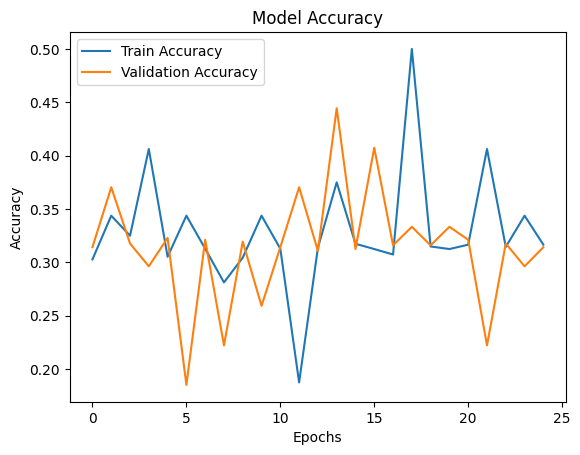

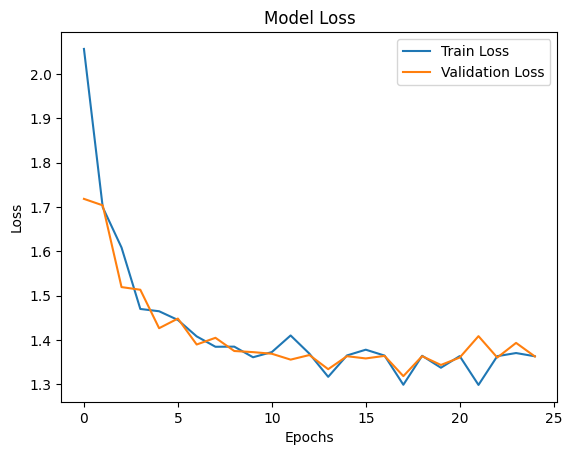

In [188]:
graphs(cnnModelHistory)

In [190]:
ftest_loss, test_acc = cnnModel.evaluate(testGenerated)
print(f"\nTest Accuracy: {test_acc}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.2418 - loss: 1.3854

Test Accuracy: 0.2575431168079376


In [194]:
def plot_accuracy_history(history1, history2):
    # Getting Accuracy values from History of both Model
    acc1 = history1.history['accuracy']
    val_acc1 = history1.history['val_accuracy']
    acc2 = history2.history['accuracy']
    val_acc2 = history2.history['val_accuracy']
    
    # Plot the training accuracy for both models
    plt.figure(figsize=(12, 6))

    plt.plot(acc1, label='MLP Model Training Accuracy')
    plt.plot(val_acc1, label='MLP Model Validation Accuracy')
    plt.plot(acc2, label='CNN Model Training Accuracy')
    plt.plot(val_acc2, label='CNN 2 Validation Accuracy')

    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


# PLOTTING CNN AND MLP GRAPH TO COMPARE BETWEEN THEM

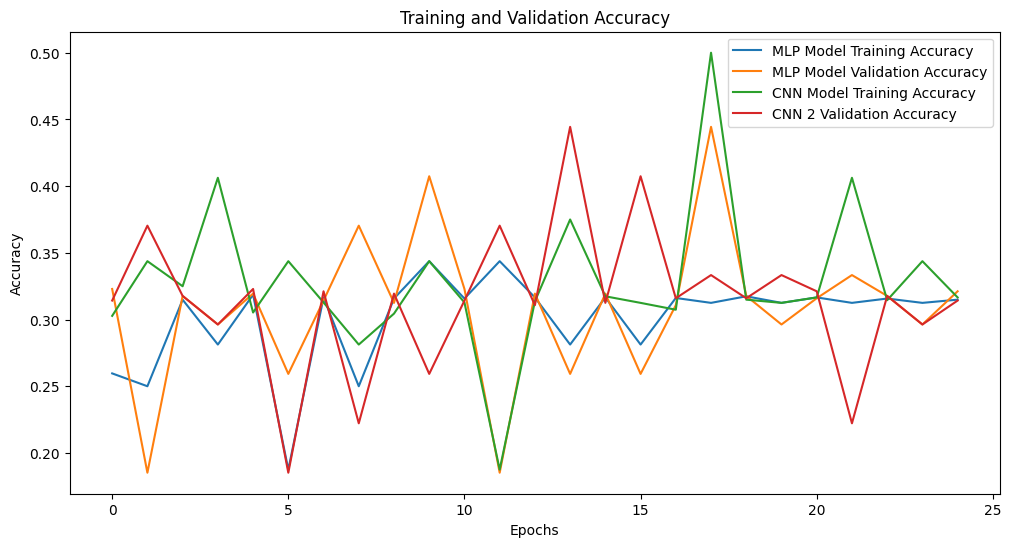

In [196]:
plot_accuracy_history(mlpModelHistory,cnnModelHistory)